In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows

from decode_tueg import (
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_chronological_vs_predicted_age, plot_age_gap_hist,
    plot_thresh_to_acc, plot_joint_scatter, plot_learning, save_fig,
    load_exp, predict_ds, plot_heatmaps
)

In [3]:
# base_dir = '/home/jovyan/new_full_runs/'
base_dir = '/home/jovyan/outdated_runs/'
exps = {
    'huber': {
         0: '220824144055632350',
         1: '220824191628058941',
         2: '220824144128724203',
         3: '220824144139015381',
         4: '220824144141880751',
    },
    'mse': {
        0: '220825094141505678',
        1: '220825094133879370',
        2: '220825094140973211',
        3: '220825094139201071',
        4: '220825141741077814',
        
    },
    'mae': {
        0: '220826151546978486',
         1: '220826104417444602',
         2: '220826104408477306',
         3: '220826104426911900',
         4: '220826104430495864',
    },
    'nll': {
        0: '220831200810717294',
    },
    # old results
#     'huber': {
#         0: '220824144254199487',
#     },
#     'nll': {
#         0: '220725141944002603'
#     },
}
# seeds = []  #  TODO: run multiple seeds
model = 'train_end'  # 'train_end', 'valid_best'
n_jobs = 6

In [4]:
only_valid = True
subsets = ['mixed']#, 'mixed', 'abnormal']
mem_efficient = True
exp_style = 'nll'

In [8]:
dfs = []
for exp_i, exp in exps[exp_style].items():
    print('exp', exp)
    clf, data_scaler, target_scaler, config = load_exp(base_dir, exp, model)
    if isinstance(data_scaler, list):
        data_scaler = data_scaler[0]  # TODO: fix this
    for subset_i, subset in enumerate(subsets):
        train, valid, mapping = get_datasets(
            config.data_path,
            config.target_name,
            subset,  # maybe skip the subset used for training. could serve as sanity check though
            int(config.n_train_recordings),
            int(config.tmin),
            int(config.tmax),
            int(config.n_jobs),
            int(config.final_eval),
            float(config.valid_set_i),
            int(config.seed),
        )
        n_channels = train[0][0].shape[0]
        t = torch.ones(1, n_channels, int(config.window_size_samples), 1).cuda()
        n_preds_per_input = clf.module(t).size()[2]
        train, valid = create_windows(
            None, 
            train,
            valid,
            int(config.window_size_samples),
            n_channels,
            n_jobs,
            int(config.preload),
            n_preds_per_input,
            test_name(int(config.final_eval)),
        )
        # order due to indexing ax_arr for plotting
        for ds_i, (ds_name, ds) in enumerate(
            [(test_name(int(config.final_eval)), valid), ('train', train)]):
            mean_train_age = train.description['age'].mean()
            if only_valid and ds_name == 'train':
                print("skipping train")
                continue
            print(f'predicting {ds_name}')
            preds, targets = predict_ds(
                clf,
                ds, 
                config.target_name,
                target_scaler,
                data_scaler,
                min(n_jobs, int(config.n_jobs)),
                mem_efficient=mem_efficient,
                trialwise=True,
                average_time_axis=True,
            )
            if config.target_name in ['age']:
                score = mean_absolute_error(targets, preds)
            else:
                score = balanced_accuracy_score(targets, preds)

            df = pd.DataFrame({
                'y_pred': preds.ravel(),
                'y_true': targets.ravel(),
                'pathological': ds.description['pathological'].to_numpy(),
                'exp': len(ds.description) * [exp],
                'subset': len(ds.description) * [subset],
                'split': len(ds.description) * [ds_name],
                'fold': len(ds.description) * [exp_i],
            })
            dfs.append(df)

exp 220831200810717294
2022-09-07 12:29:52 DEBUG    indexing files
2022-09-07 12:29:52 DEBUG    indexing files
2022-09-07 12:32:18 INFO     validation run, removing eval from dataset with 2993 recordings
2022-09-07 12:32:18 INFO     validation run, removing eval from dataset with 2993 recordings
2022-09-07 12:32:18 DEBUG    into train (0.9) and eval (0.1).
2022-09-07 12:32:18 DEBUG    into train (0.9) and eval (0.1).
2022-09-07 12:32:19 DEBUG    splitting dataset with 2693 recordings
2022-09-07 12:32:19 DEBUG    splitting dataset with 2693 recordings
2022-09-07 12:32:19 DEBUG    into train (.8) and valid (.2).
2022-09-07 12:32:19 DEBUG    into train (.8) and valid (.2).
2022-09-07 12:32:19 DEBUG    from train (2154) and valid (539) selecting mixed
2022-09-07 12:32:19 DEBUG    from train (2154) and valid (539) selecting mixed
2022-09-07 12:32:19 DEBUG    selected train (2154) and valid (539)
2022-09-07 12:32:19 DEBUG    selected train (2154) and valid (539)
2022-09-07 12:32:19 DEBUG    

In [9]:
df_concat = pd.concat(dfs).reset_index()

In [23]:
df_concat

,index,y_pred,y_true,pathological,exp,subset,split,fold
0,0,51,53.0,False,220831200810717294,mixed,valid,0
1,1,40,32.0,False,220831200810717294,mixed,valid,0
2,2,32,39.0,False,220831200810717294,mixed,valid,0
3,3,54,69.0,True,220831200810717294,mixed,valid,0
4,4,55,28.0,False,220831200810717294,mixed,valid,0
...,...,...,...,...,...,...,...,...
534,534,48,59.0,False,220831200810717294,mixed,valid,0
535,535,36,39.0,True,220831200810717294,mixed,valid,0
536,536,49,24.0,True,220831200810717294,mixed,valid,0
537,537,27,28.0,False,220831200810717294,mixed,valid,0


In [11]:
#TODO: manually do the jointplot (distplot, regplot, kdeplot)
#TODO: plot the gap proxy for normal / pathological indivudally?
#TODO: update colors

In [ ]:
plot_only_valid = False
this_df_concat = df_concat[df_concat.split == 'valid'] if plot_only_valid else df_concat

split valid subset mixed  (539, 8)


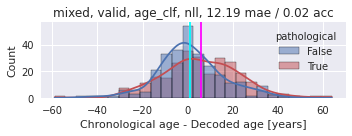

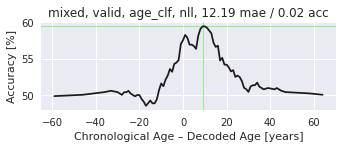

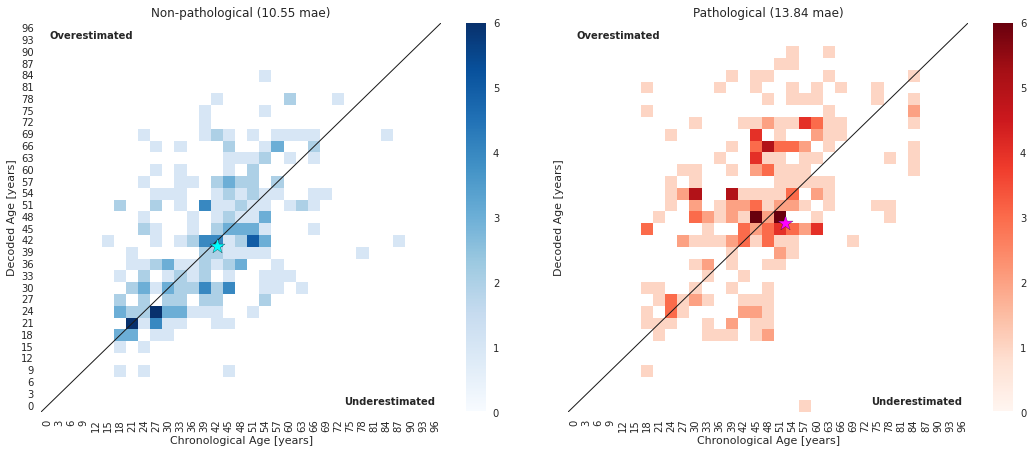

In [22]:
grouping = ['split', 'subset']#, 'fold']
splits = list(this_df_concat.split.unique())
n_splits = len(splits) 
subsets = list(this_df_concat.subset.unique())
n_subsets = len(subsets)
fig2, ax_arr2 = plt.subplots(
    n_splits, n_subsets, figsize=(5*n_subsets, 2*n_splits), squeeze=False, sharex=True)
fig3, ax_arr3 = plt.subplots(
    n_splits, n_subsets, figsize=(5*n_subsets, 2*n_splits), squeeze=False, sharex=True)
for x, df in this_df_concat.groupby(grouping):
    split_i = splits.index(x[0])
    subset_i = subsets.index(x[1])
    fold = '' if len(x) == 2 else x[2]
    print('split', x[0], 'subset', x[1], fold, df.shape)

    mae = mean_absolute_error(df.y_true, df.y_pred)
    title = f"{x[1]}, {x[0]}, {config.target_name}, {config.loss}, {mae:.2f} mae"
    if config.target_name != 'age':
        bal_acc = balanced_accuracy_score(df.y_true, df.y_pred)
        title += f" / {bal_acc:.2f} acc"
    ax4 = plot_heatmaps(df, 3, 100)
#     ax4.fig.subplots_adjust(top=0.94)
#     ax4.fig.suptitle(title);

    ax2 = plot_age_gap_hist(
        df,
        ax=ax_arr2[split_i, subset_i],
    )
    ax2.figure.tight_layout()
    ax2.set_title(title)

    ax3 = plot_thresh_to_acc(
        df,
        ax=ax_arr3[split_i, subset_i],
    )
    ax3.figure.tight_layout()
    ax3.set_title(title)

<AxesSubplot:xlabel='Epoch', ylabel='nll'>

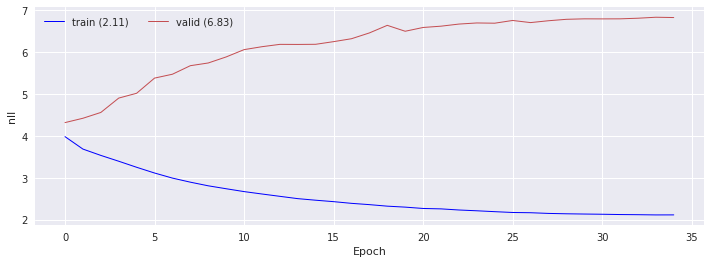

In [14]:
plot_learning(
    pd.DataFrame(clf.history),
    'loss',
    'nll',
    'valid'
)

In [42]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.metrics import mean_absolute_error

In [43]:
df = pd.read_csv('/home/jovyan/220824_5fcv_huber.csv', index_col=0)

In [44]:
# only look at valid set
df = df[df.split == 'valid']

In [45]:
df.shape

(5386, 8)

In [46]:
mean_absolute_error(df.y_true, df.y_pred)

9.395337378707762

In [47]:
mean_absolute_error(df[df.pathological].y_true, df[df.pathological].y_pred)

11.63164204531722

In [48]:
mean_absolute_error(df[~df.pathological].y_true, df[~df.pathological].y_pred)

7.232541631015341

In [49]:
def jointplot(df):
    grid = sns.JointGrid(height=9)
    sns.lineplot(x=[0, 100], y=[0, 100], ax=grid.ax_joint, color='magenta', linestyle='--')

    x = 'y_pred'
    y = 'y_true'
    hue = 'pathological'
    max_age = 100
    for d, c in [(df[~df.pathological], 'black'), (df[df.pathological], 'white')]:
        sns.scatterplot(data=d, x=x, y=y, ax=grid.ax_joint, edgecolor=c, alpha=.8)

    for d in [df[~df.pathological], df[df.pathological]]:
        m, b = np.polyfit(d.y_true.to_numpy('int'), d.y_pred.to_numpy('float'), 1)
        grid.ax_joint.plot(m*d.y_true + b, d.y_true, linewidth=1)

    sns.scatterplot(data=df.groupby(hue, as_index=False).mean(), 
                    x=x, y=y, ax=grid.ax_joint, hue=hue, marker='^', s=200, edgecolor='black')

    sns.histplot(data=df, y=y, ax=grid.ax_marg_y, kde=True, 
                 hue=hue, legend=None, stat='density', bins=list(range(max_age)))
    sns.kdeplot(data=df, y=y, ax=grid.ax_marg_y, legend=None, color='black')

    sns.histplot(data=df, x=x, ax=grid.ax_marg_x, kde=True, 
                 hue=hue, legend=None, stat='density', bins=list(range(max_age)))
    sns.kdeplot(data=df, x=x, ax=grid.ax_marg_x, legend=None, color='black')

    grid.ax_joint.set_ylabel('Chronological Age [years]')
    grid.ax_joint.set_xlabel('Decoded Age [years]')
    return grid

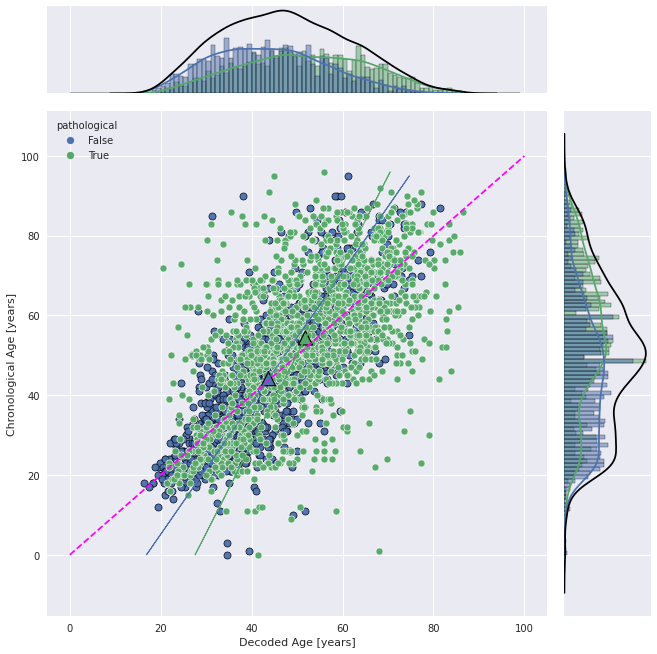

In [50]:
jointplot(df)

In [51]:
from decode_tueg import plot_heatmaps, plot_age_gap_hist, plot_thresh_to_acc

In [52]:
bin_size = 3
max_age = 100
hist_max_count = 450

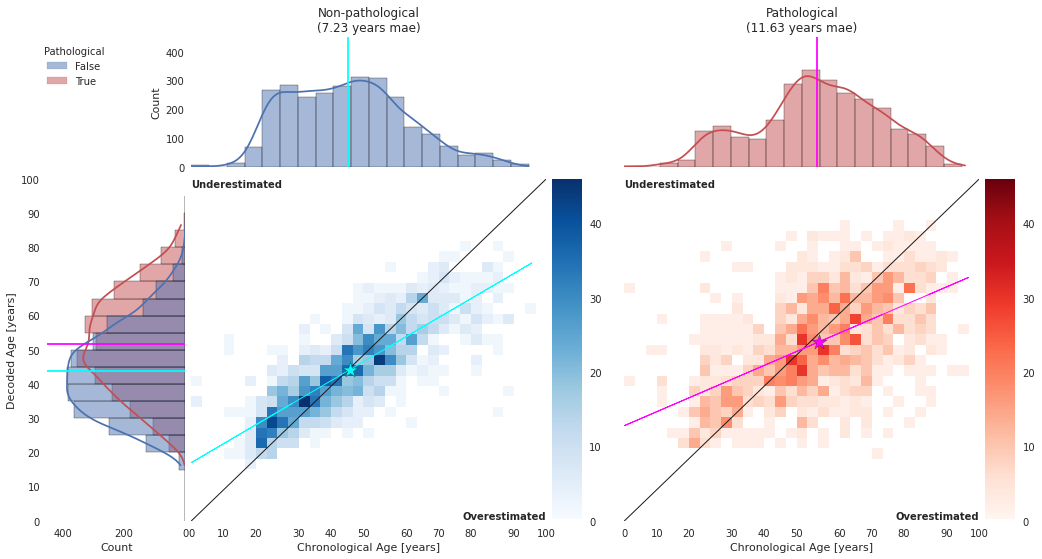

In [54]:
fig = plot_heatmaps(df, bin_size, max_age, hist_max_count)
# fig.savefig('/home/jovyan/new2dhist.png', bbox_inches='tight', dpi=300)

(0.0, 100.0)

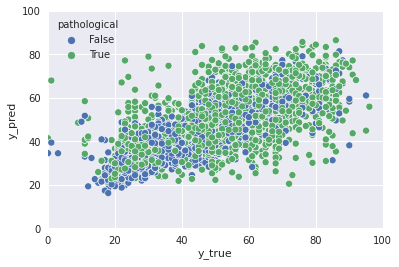

In [17]:
ax = sns.scatterplot(data=df, x='y_true', y='y_pred', hue='pathological')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

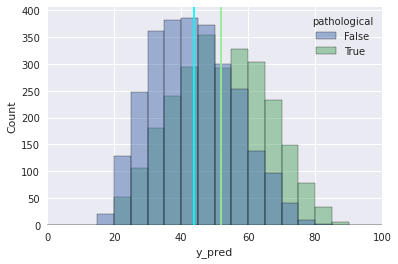

In [18]:
ax = sns.histplot(data=df, x='y_pred', hue='pathological', bins=np.linspace(0, 100, 21))
ax.set_xlim(0, 100)
ax.axvline(df[df.pathological].y_pred.mean(), c='lightgreen')
ax.axvline(df[~df.pathological].y_pred.mean(), c='cyan')

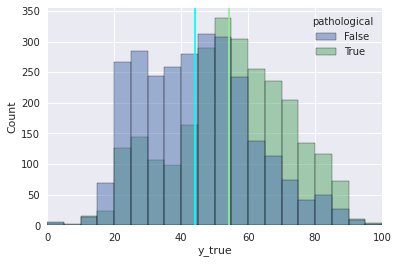

In [19]:
ax = sns.histplot(data=df, x='y_true', hue='pathological', bins=np.linspace(0, 100, 21))
ax.set_xlim(0, 100)
ax.axvline(df[df.pathological].y_true.mean(), c='lightgreen')
ax.axvline(df[~df.pathological].y_true.mean(), c='cyan')

In [20]:
bin_size = 2
max_age = 100

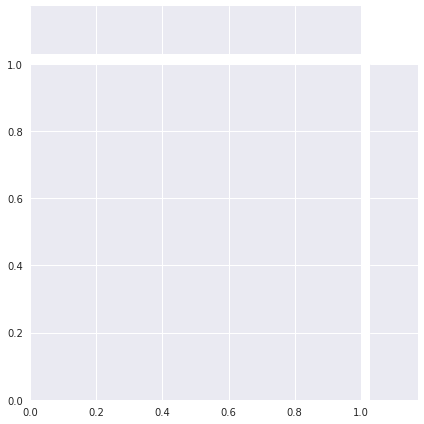

In [21]:
grid = sns.JointGrid(height=6, ratio=6)

In [22]:
H, xedges, yedges = np.histogram2d(
    df.y_true, df.y_pred, 
    bins=max_age//bin_size, range=[[0, max_age], [0, max_age]],
)

In [23]:
ax = grid.ax_joint
cmap = 'Reds'
vmax = None

In [24]:
ax.plot([0, 100], [0, 100], c='k', linewidth=1)
ax = sns.heatmap(H, ax=ax, cmap=cmap, vmin=0, vmax=vmax, cbar=False)
ax.invert_yaxis()

#     m, b = np.polyfit(df.y_true.to_numpy('int')/bin_size, df.y_pred.to_numpy('float')/bin_size, 1)
#     ax.plot(m*df.y_true + b, df.y_true, linewidth=1, color='magenta' if cmap == 'Reds' else 'cyan', label='trend')

ax.scatter(
    df.y_true.mean()/bin_size, df.y_pred.mean()/bin_size,
    marker='*', c='magenta' if cmap == 'Reds' else 'cyan', 
    s=300, edgecolor='k' if cmap == 'Reds' else 'w', zorder=3)

#     ax.axvline(df.y_true.mean()/bin_size, linestyle='--', color='r' if cmap == 'Reds' else 'b')
#     ax.axhline(df.y_pred.mean()/bin_size, linestyle='--', color='r' if cmap == 'Reds' else 'b')

ticklabels = [t.get_text() for t in ax.get_xticklabels()]
ticklabels = [str(int(t)*bin_size) for t in ticklabels]
ax.set_xticklabels(ticklabels)
ax.set_yticklabels(ticklabels)
ax.set_xlabel('Chronological Age [years]')
ax.set_ylabel('Decoded Age [years]')

xoffset = 12
yoffset = 2
ax.text(ax.get_xlim()[1]-xoffset*2/bin_size, 1*2/bin_size, 'Underestimated', weight='bold')
ax.text(1*2/bin_size, ax.get_ylim()[1]-yoffset*2/bin_size, 'Overestimated', weight='bold')

Text(1.0, 48.0, 'Overestimated')

In [25]:
sns.histplot(ax=grid.ax_marg_x, x=df.y_true/bin_size, bins=100, color='r', kde=True)
sns.histplot(ax=grid.ax_marg_y, y=df.y_pred/bin_size, bins=100, color='r', kde=True)

<AxesSubplot:xlabel='Count', ylabel='y_pred'>

In [26]:
grid.ax_marg_x.axvline((df.y_true/bin_size).mean(), color='magenta')
grid.ax_marg_y.axhline((df.y_pred/bin_size).mean(), color='magenta')

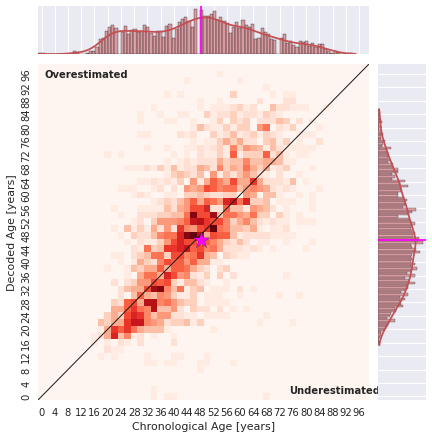

In [27]:
# https://stackoverflow.com/questions/60845764/colorbar-for-sns-jointplot-kde-style-on-the-side
grid.fig

In [28]:
df['gap'] = df.y_true - df.y_pred

In [29]:
df

,index,y_pred,y_true,pathological,exp,subset,split,fold,gap
0,0,47.562190,55.0,False,220824144139015381,normal,valid,3,7.437810
1,1,63.435150,70.0,False,220824144139015381,normal,valid,3,6.564850
2,2,40.898357,39.0,False,220824144139015381,normal,valid,3,-1.898357
3,3,58.216160,59.0,False,220824144139015381,normal,valid,3,0.783840
4,4,26.794992,24.0,False,220824144139015381,normal,valid,3,-2.794992
...,...,...,...,...,...,...,...,...,...
25869,263,40.523224,62.0,True,220824144055632350,abnormal,valid,0,21.476776
25870,264,71.378365,74.0,True,220824144055632350,abnormal,valid,0,2.621635
25871,265,26.243753,39.0,True,220824144055632350,abnormal,valid,0,12.756247
25872,266,69.686516,24.0,True,220824144055632350,abnormal,valid,0,-45.686516


In [30]:
# are the two groups pathological gaps and non-pathological gaps uniform?

Text(0.5, 1.0, '')

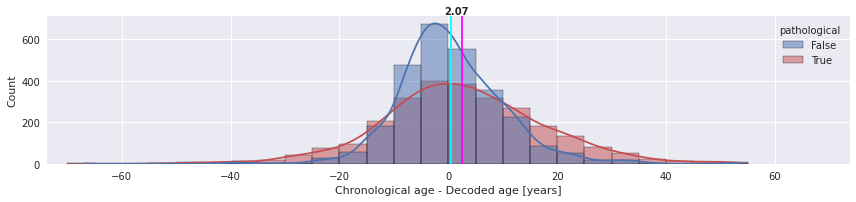

In [31]:
ax = plot_age_gap_hist(df)
ax.get_figure().tight_layout()
ax.set_title('')
# ax.get_figure().savefig('/home/jovyan/age_gap.png', dpi=300, bbox_inches='tight')

Text(0.5, 24.000000000000043, 'Chronological age [years]')

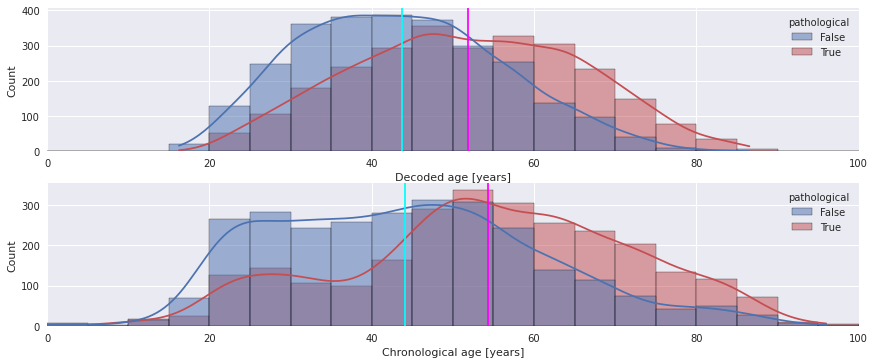

In [32]:
fig, ax_arr = plt.subplots(2, 1, figsize=(12,5))
fig.tight_layout()
ax = ax_arr[0]
ax = sns.histplot(data=df, x='y_pred', hue='pathological', ax=ax, kde=True, palette=['b', 'r'], bins=np.linspace(0, 100, 21))
ax.axvline(df[~df.pathological].y_pred.mean(), c='cyan')
ax.axvline(df[df.pathological].y_pred.mean(), c='magenta')
ax.set_xlim(0, 100)
ax.set_xlabel('Decoded age [years]')

ax = ax_arr[1]
ax = sns.histplot(data=df, hue='pathological', x='y_true', ax=ax, kde=True, palette=['b', 'r'], bins=np.linspace(0, 100, 21))
ax.axvline(df[~df.pathological].y_true.mean(), c='cyan')
ax.axvline(df[df.pathological].y_true.mean(), c='magenta')
ax.set_xlim(0, 100)
ax.set_xlabel('Chronological age [years]')
# ax.get_figure().savefig('/home/jovyan/age_pred_hist.png', dpi=300, bbox_inches='tight')

In [33]:
histories = [pd.read_csv(f'/home/jovyan/new_full_runs/{exp}/history.csv', index_col=0) for exp in df.exp.unique()]

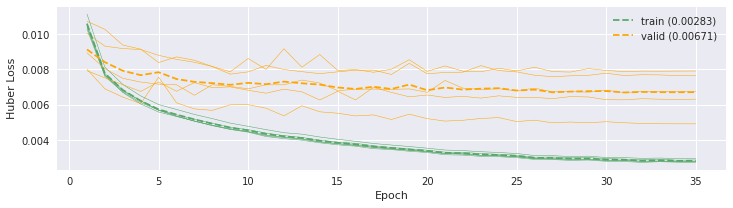

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
for history in histories:
    ax = sns.lineplot(data=history, y='train_loss', x='epoch', ax=ax, c='g', linewidth=.5)
    ax = sns.lineplot(data=history, y='valid_loss', x='epoch', ax=ax, c='orange', linewidth=.5)

mean_train_loss = np.mean([history['train_loss'] for history in histories], axis=0)
sns.lineplot(x=history['epoch'], y=mean_train_loss, linestyle='--', c='g', 
             label=f'train ({mean_train_loss[-1]:.5f})')
mean_valid_loss = np.mean([history['valid_loss'] for history in histories], axis=0)
sns.lineplot(x=history['epoch'], y=mean_valid_loss, linestyle='--', c='orange', 
             label=f'valid ({mean_valid_loss[-1]:.5f})')
ax.set_ylabel('Huber Loss')
ax.set_xlabel('Epoch')
ax.legend()
# fig.savefig('/home/jovyan/curves.png', bbox_inches='tight', dpi=300)

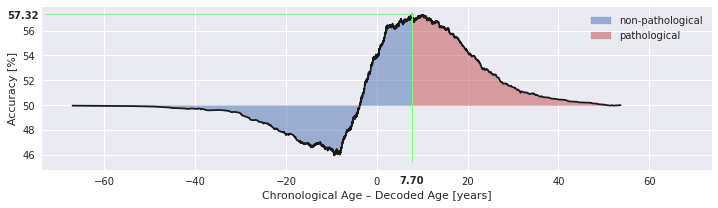

In [68]:
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax = plot_thresh_to_acc(df, ax=ax)
# ax.set_ylim(45,58)
# ax.set_xlim(-70,70)
# fig.savefig('/home/jovyan/proxy.png', bbox_inches='tight', dpi=300)

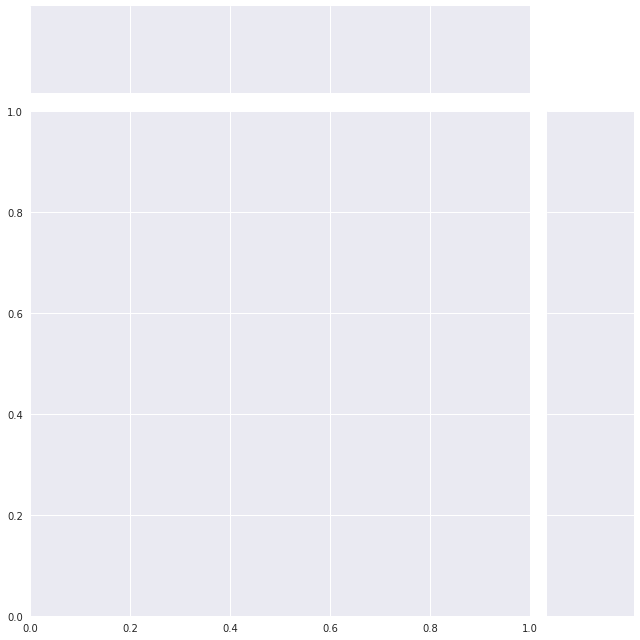

In [98]:
grid = sns.JointGrid(height=9)

In [105]:
df_patho = df[df.pathological]
df_non_patho = df[~df.pathological]

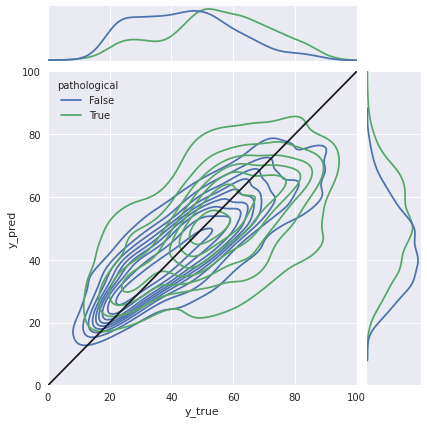

In [110]:
grid = sns.jointplot(data=df, x='y_true', y='y_pred', hue='pathological', kind='kde')
grid.ax_joint.set_xlim(0, 100)
grid.ax_joint.set_ylim(0, 100)
grid.ax_joint.plot([0, 100], [0, 100], c='k')

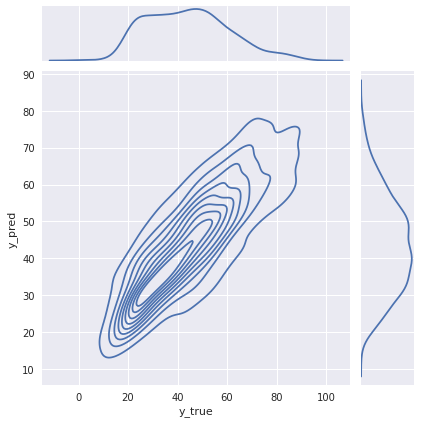

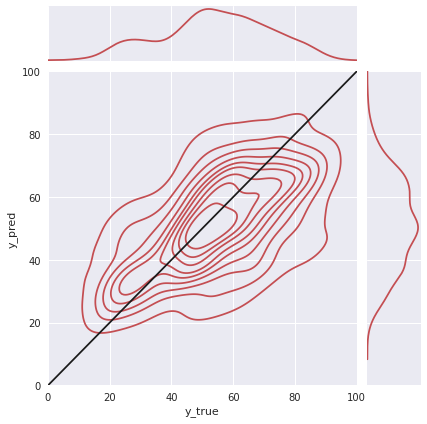

In [106]:
ax = sns.jointplot(x=df_non_patho.y_true, y=df_non_patho.y_pred, kind='kde', color='b')
ax = sns.jointplot(x=df_patho.y_true, y=df_patho.y_pred, kind='kde', color='r', ax=ax.ax_joint)
ax.ax_joint.set_xlim(0, 100)
ax.ax_joint.set_ylim(0, 100)
ax.ax_joint.plot([0, 100], [0, 100], c='k')

In [60]:
df

,index,y_pred,y_true,pathological,exp,subset,split,fold
0,0,47.562190,55.0,False,220824144139015381,normal,valid,3
1,1,63.435150,70.0,False,220824144139015381,normal,valid,3
2,2,40.898357,39.0,False,220824144139015381,normal,valid,3
3,3,58.216160,59.0,False,220824144139015381,normal,valid,3
4,4,26.794992,24.0,False,220824144139015381,normal,valid,3
...,...,...,...,...,...,...,...,...
25869,263,40.523224,62.0,True,220824144055632350,abnormal,valid,0
25870,264,71.378365,74.0,True,220824144055632350,abnormal,valid,0
25871,265,26.243753,39.0,True,220824144055632350,abnormal,valid,0
25872,266,69.686516,24.0,True,220824144055632350,abnormal,valid,0


In [39]:
subject_wise = False
bin_size=3
max_age=100
hist_max_count=2200 if not subject_wise else 100

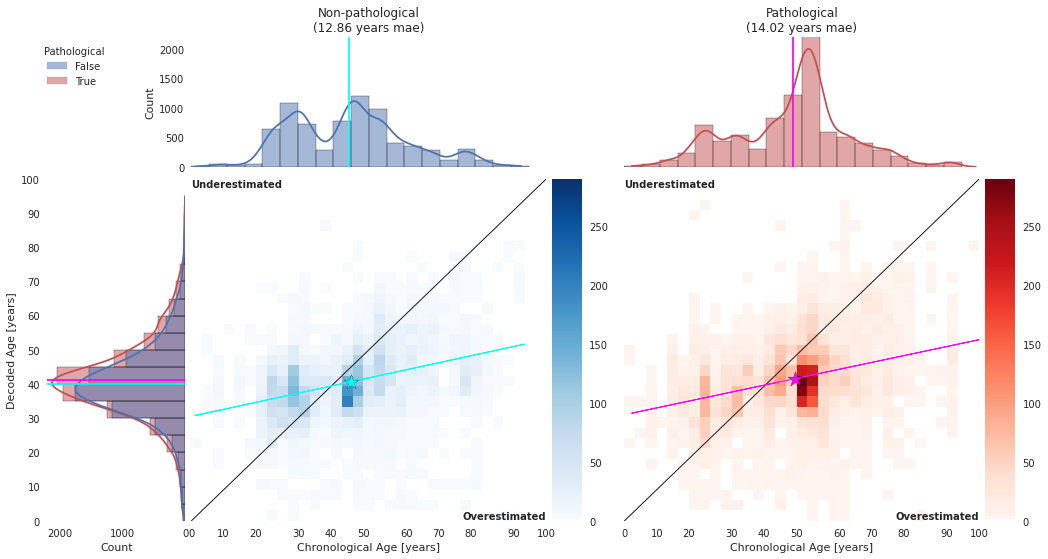

In [40]:
# fdescribe i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
longitudinal = 'transition'
df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
# --- hack
with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
    ds = pickle.load(f)
df['subject'] = ds.description['subject']
# ---
if subject_wise:
    df = df.groupby(['subject', 'pathological'], as_index=False).mean()

ax_arr = plot_heatmaps(df, bin_size, max_age, hist_max_count)
s = 'recording' if not subject_wise else 'subject'
ax_arr.get_figure().savefig(
    f'/home/jovyan/longitudinal_{longitudinal}_chronological_vs_predicted_{s}_age.png',
    dpi=300, bbox_inches='tight')

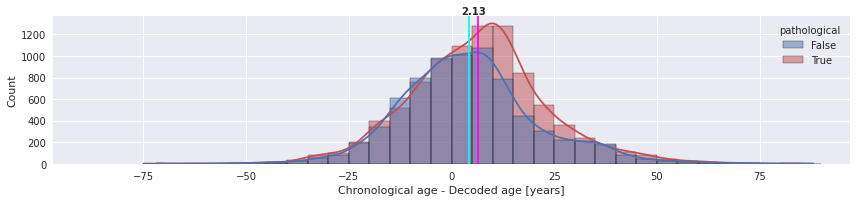

In [41]:
ax = plot_age_gap_hist(df)
ax.get_figure().tight_layout()
ax.set_title('')
s = 'recording' if not subject_wise else 'subject'
ax.get_figure().savefig(
    f'/home/jovyan/longitudinal_transition_{s}_age_gap.png', 
    dpi=300, bbox_inches='tight')

Text(0.5, 24.000000000000043, 'Chronological age [years]')

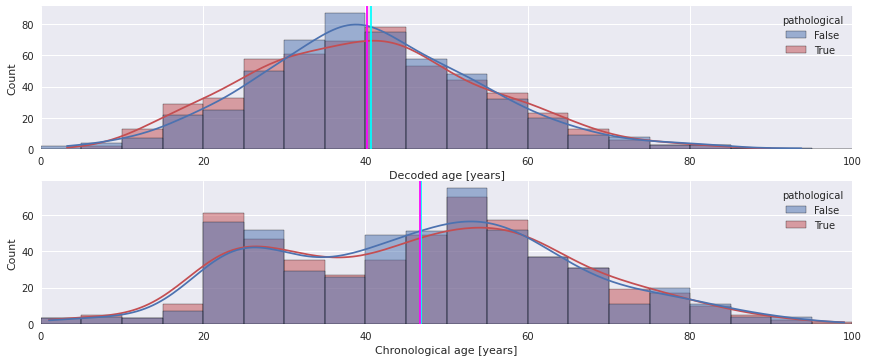

In [324]:
fig, ax_arr = plt.subplots(2, 1, figsize=(12,5))
fig.tight_layout()
ax = ax_arr[0]
ax = sns.histplot(data=df, x='y_pred', hue='pathological', ax=ax, kde=True, palette=['b', 'r'], bins=np.linspace(0, 100, 21))
ax.axvline(df[~df.pathological].y_pred.mean(), c='cyan')
ax.axvline(df[df.pathological].y_pred.mean(), c='magenta')
ax.set_xlim(0, 100)
ax.set_xlabel('Decoded age [years]')

ax = ax_arr[1]
ax = sns.histplot(data=df, hue='pathological', x='y_true', ax=ax, kde=True, palette=['b', 'r'], bins=np.linspace(0, 100, 21))
ax.axvline(df[~df.pathological].y_true.mean(), c='cyan')
ax.axvline(df[df.pathological].y_true.mean(), c='magenta')
ax.set_xlim(0, 100)
ax.set_xlabel('Chronological age [years]')
# ax.get_figure().savefig('/home/jovyan/longitudinal_transition_subject_age_pred_hist.png', dpi=300, bbox_inches='tight')

In [364]:
def create_grid():
    #https://stackoverflow.com/questions/10388462/matplotlib-different-size-subplots
    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    gridx = 12
    gridy = 12
    ax0 = plt.subplot2grid((gridx, gridy), (0, 2), colspan=5, rowspan=2)
    ax1 = plt.subplot2grid((gridx, gridy), (0, 7), colspan=5, rowspan=2)

    ax2 = plt.subplot2grid((gridx, gridy), (2, 0), rowspan=5, colspan=2)
    ax2.invert_xaxis()
    ax3 = plt.subplot2grid((gridx, gridy), (2, 2), rowspan=5, colspan=5)
    ax4 = plt.subplot2grid((gridx, gridy), (2, 7), rowspan=5, colspan=5)

    xlim = (-5, 105)
    ylim = (-5, 105)
    hist_max_count = 100
    ax0.set_title('Test1')
    ax0.set_xlim(xlim)
    ax0.set_ylim([0, hist_max_count])
    ax0.set_xticklabels([])
    ax0.set_xlabel(' ')
    ax1.set_title('Test2')
    ax1.set_xlim(xlim)
    ax1.set_ylim([0, hist_max_count])
    ax1.set_xticklabels([])
    ax1.set_xlabel(' ')
    ax1.set_yticklabels([])
    ax1.set_ylabel(' ')
    ax2.set_ylim(ylim)
    ax2.set_xlim([hist_max_count, 0])
    ax2.set_ylabel('Decoded Age [years]')
    ax3.set_ylim(ylim)
    ax3.set_yticklabels([])
    ax3.set_ylabel(' ')
    ax3.set_xlabel('Chronological Age [years]')
    ax4.set_ylim(ylim)
    ax4.set_yticklabels([])
    ax4.set_ylabel(' ')
    ax4.set_xlabel('Chronological Age [years]')
    return fig, ax0, ax1, ax2, ax3, ax4

In [367]:
def complicated_plot(df):
    fig, ax0, ax1, ax2, ax3, ax4 = create_grid()
    sns.histplot(df[~df.pathological].y_true, ax=ax0, color='b', kde=True)
    ax0.axvline(df[~df.pathological].y_true.mean(), c='cyan')
    sns.histplot(df[df.pathological].y_true, ax=ax1, color='r', kde=True)
    ax1.axvline(df[~df.pathological].y_true.mean(), c='magenta')

    sns.histplot(data=df, y='y_pred', ax=ax2, hue='pathological', palette=['b', 'r'], kde=True)
    ax2.axhline(df[~df.pathological].y_pred.mean(), c='cyan')
    ax2.axhline(df[df.pathological].y_pred.mean(), c='magenta')

    sns.scatterplot(data=df[~df.pathological], x='y_true', y='y_pred', ax=ax3, c='b')
    sns.lineplot(x=[0, 100], y=[0, 100], ax=ax3, c='k')
    sns.scatterplot(data=df[~df.pathological].mean().to_frame().T, x='y_true', y='y_pred',
                    ax=ax3, c='cyan', marker='*', s=300)
    sns.scatterplot(data=df[df.pathological], x='y_true', y='y_pred', ax=ax4, c='r')
    sns.lineplot(x=[0, 100], y=[0, 100], ax=ax4, c='k')
    sns.scatterplot(data=df[df.pathological].mean().to_frame().T, x='y_true', y='y_pred', 
                    ax=ax4, c='magenta', marker='*', s=300)
    return fig

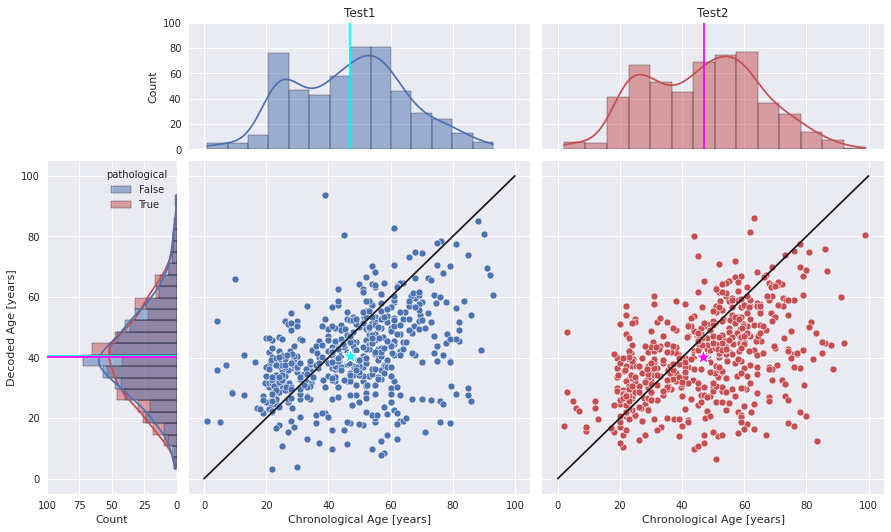

In [368]:
fig = complicated_plot(df)

In [406]:
fig = plot_heatmaps(df, 3, 100)

TypeError: plot_heatmaps() missing 1 required positional argument: 'hist_max_count'

In [ ]:
sns.histplot(df[df.pathological].y_true, ax=ax_arr[0, 2])
sns.histplot(y=df[~df.pathological].y_pred, ax=ax_arr[1, 0])
sns.histplot(y=df[df.pathological].y_pred, ax=ax_arr[1, 0])
ax_arr[1, 0].invert_xaxis()

sns.scatterplot(data=df[~df.pathological], x='y_true', y='y_pred', ax=ax_arr[1, 1])
sns.scatterplot(data=df[df.pathological], x='y_true', y='y_pred', ax=ax_arr[1, 2])

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

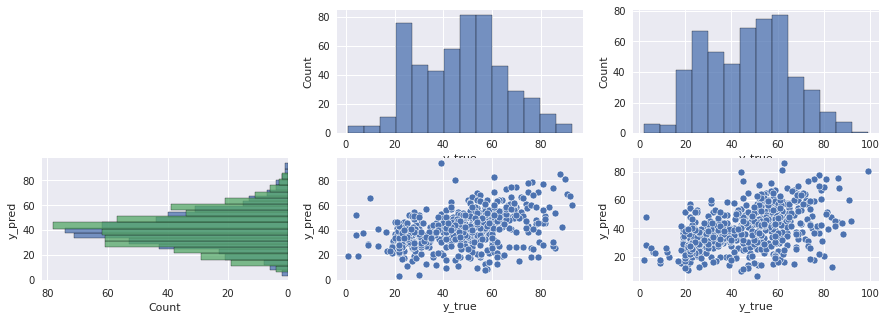

In [88]:
fig, ax_arr = plt.subplots(2, 3, figsize=(15,5))
ax_arr[0,0].set_facecolor('white')
# ax_arr[0,0].grid(False)
ax_arr[0,0].set_xticklabels([])
ax_arr[0,0].set_yticklabels([])

sns.histplot(df[~df.pathological].y_true, ax=ax_arr[0, 1])
sns.histplot(df[df.pathological].y_true, ax=ax_arr[0, 2])
sns.histplot(y=df[~df.pathological].y_pred, ax=ax_arr[1, 0])
sns.histplot(y=df[df.pathological].y_pred, ax=ax_arr[1, 0])
ax_arr[1, 0].invert_xaxis()

sns.scatterplot(data=df[~df.pathological], x='y_true', y='y_pred', ax=ax_arr[1, 1])
sns.scatterplot(data=df[df.pathological], x='y_true', y='y_pred', ax=ax_arr[1, 2])
plt.subplots_adjust()